```{contents}
```

# Cost Function

* HC iteratively merges (agglomerative) or splits (divisive) clusters based on **inter-point distances**.
* The goal is to **form clusters such that points in the same cluster are similar** and points in different clusters are dissimilar.

> The “cost” is implicit: it’s the **distance between clusters** used in the merge or split decisions.

---

## **2. Agglomerative Clustering**

In agglomerative HC, each step merges the **two clusters with the smallest distance**, according to a **linkage criterion**.

### **Common Linkage Criteria**

| Linkage  | How Distance is Measured                    | “Implicit Cost”                                                          |
| -------- | ------------------------------------------- | ------------------------------------------------------------------------ |
| Single   | Minimum distance between points of clusters | Merge cost = min distance; encourages chaining                           |
| Complete | Maximum distance between points             | Merge cost = max distance; encourages compact clusters                   |
| Average  | Average distance between all points         | Merge cost = average pairwise distance                                   |
| Ward     | Increase in within-cluster variance         | Merge cost = increase in total variance; explicitly tries to minimize it |

* **Ward linkage** is the only one that can be viewed as minimizing an **explicit cost function**:

$$
\text{Cost} = \sum_{c} \sum_{x_i \in c} ||x_i - \mu_c||^2
$$

* Each merge is chosen to **minimize the increase in total within-cluster variance**.

---

## **3. Divisive Clustering**

* Divisive HC splits clusters to **maximize dissimilarity within sub-clusters** or **minimize within-cluster variance**.
* If using **K-Means for splits**, the cost function is essentially the **sum of squared distances to cluster centroids** for each split.

$$
\text{Cost}_{split} = \sum_{k=1}^{K} \sum_{x_i \in C_k} ||x_i - \mu_k||^2
$$

* Each split is chosen to minimize this cost.

---

**Key Takeaways**

1. **HC is distance-driven, not optimization-driven** (except Ward linkage).
2. **“Cost” depends on linkage method**:

   * Single → distance between nearest points
   * Complete → distance between farthest points
   * Average → average distance
   * Ward → variance increase (closest to a formal cost function)
3. **Dendrogram height reflects the cost/distance** at which clusters were merged or split.
4. **No global objective function** exists for general HC; it’s a **greedy, hierarchical process**.

---

**Intuition**

* Think of **HC as building a tree based on distance costs**:

  * Each merge/split chooses the “cheapest” operation according to the chosen metric.
  * Ward linkage explicitly tries to minimize total variance, making it the most “cost-function-like” version of HC.

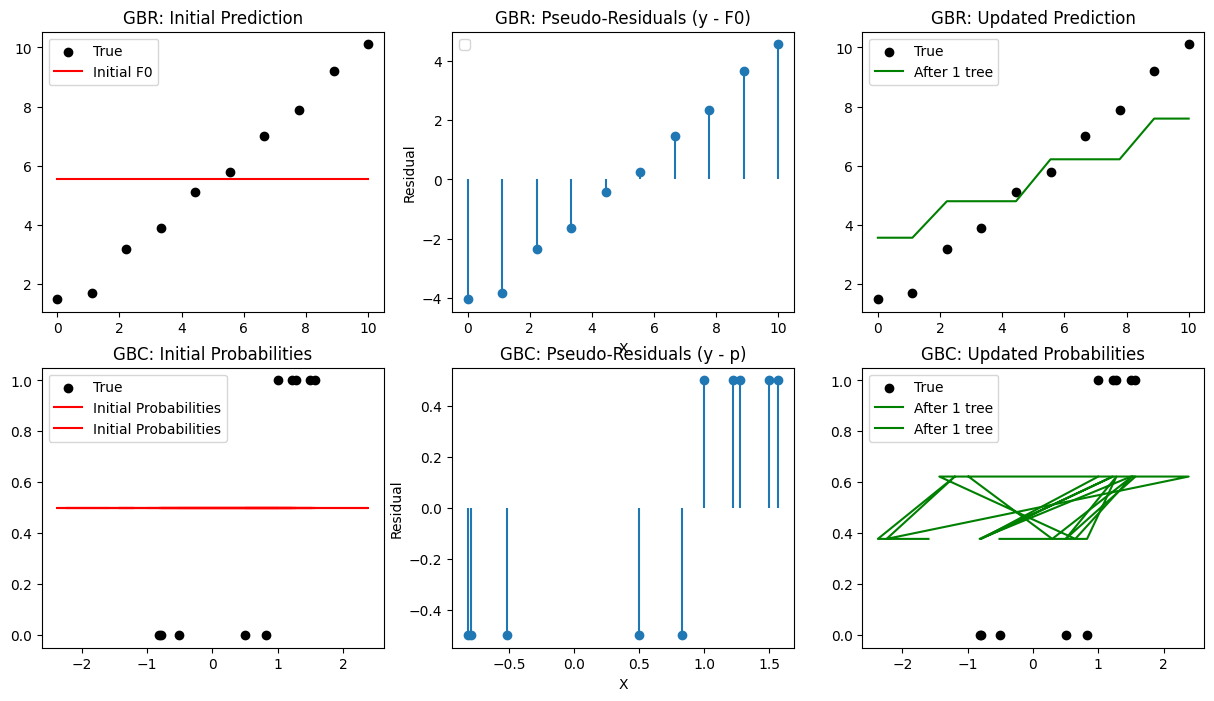

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from scipy.special import expit  # sigmoid
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Part 1: Gradient Boosting Regressor (GBR)
# -------------------------------
# Dataset
X_reg = np.linspace(0, 10, 10).reshape(-1,1)
y_reg = np.array([1.5, 1.7, 3.2, 3.9, 5.1, 5.8, 7.0, 7.9, 9.2, 10.1])

# Initialize prediction (F0)
F0 = np.mean(y_reg)
Fm = np.full_like(y_reg, F0, dtype=float)

plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plt.scatter(X_reg, y_reg, color='black', label='True')
plt.plot(X_reg, Fm, color='red', label='Initial F0')
plt.title("GBR: Initial Prediction")
plt.legend()

# Compute pseudo-residuals (MSE)
residuals = y_reg - Fm
plt.subplot(2,3,2)
plt.stem(X_reg, residuals, basefmt=" ")
plt.title("GBR: Pseudo-Residuals (y - F0)")
plt.xlabel("X")
plt.ylabel("Residual")
plt.legend()

# Fit a weak learner
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X_reg, residuals)
pred = tree.predict(X_reg)
Fm += 0.5 * pred  # learning_rate=0.5

plt.subplot(2,3,3)
plt.scatter(X_reg, y_reg, color='black', label='True')
plt.plot(X_reg, Fm, color='green', label='After 1 tree')
plt.title("GBR: Updated Prediction")
plt.legend()



# -------------------------------
# Part 2: Gradient Boosting Classifier (GBC)
# -------------------------------
# Binary classification dataset
X_clf, y_clf = make_classification(
    n_samples=10,
    n_features=2,      # must be >= log2(n_classes*n_clusters_per_class)
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=0
)
y_clf = y_clf.reshape(-1,1)

# Initialize prediction (F0 for log-odds)
p0 = np.mean(y_clf)
F0 = np.log(p0/(1-p0))
Fm = np.full_like(y_clf, F0, dtype=float)

# Compute pseudo-residuals
p = expit(Fm)  # sigmoid probabilities
residuals = y_clf - p


plt.subplot(2,3,4)
plt.scatter(X_clf[:,0], y_clf, color='black', label='True')

plt.plot(X_clf, p, color='red', label='Initial Probabilities')
plt.title("GBC: Initial Probabilities")
plt.legend()

plt.subplot(2,3,5)
plt.stem(X_clf[:,0], residuals, basefmt=" ")
plt.title("GBC: Pseudo-Residuals (y - p)")
plt.xlabel("X")
plt.ylabel("Residual")

# Fit weak learner
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X_clf, residuals)
pred = tree.predict(X_clf)
Fm = Fm.flatten()       # shape (10,)
pred = pred.flatten()   # shape (10,)
Fm += 0.5 * pred        # works

Fm += 0.5 * pred  # learning_rate=0.5
p = expit(Fm)

plt.subplot(2,3,6)
plt.scatter(X_clf[:,0], y_clf, color='black', label='True')
plt.plot(X_clf, p, color='green', label='After 1 tree')
plt.title("GBC: Updated Probabilities")
plt.legend()
plt.show()
